# GSFit reconstructs MAST-U from synthetic magnetic diagnostics generated by FreeGSNKE
The equilibrium reconstruction problem is 'ill posed', there are a finite number of sensors.
There is no formal guarantee that the equilibrium reconstruction will be the same as the equilibrium used to create the measurements.
There could even be multiple solutions that equally match the magnetic measurements.

In [1]:
import os

import gsfit_rs
import matplotlib.pyplot as plt
import numpy as np
import shapely
from datetime import datetime
from gsfit import Gsfit
from scipy.constants import mu_0

# %matplotlib widget
%matplotlib inline

print(datetime.now())

2025-10-26 11:01:32.081274


# 1. FreeGSNKE synthetic equilibrium data
We start by constructing a FreeGSNKE equilibrium, including MAST-U's magnetic probes.

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> built from pickle file.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 3.69e-10 (vs. requested 1.00e-09) reached in 26/100 iterations.


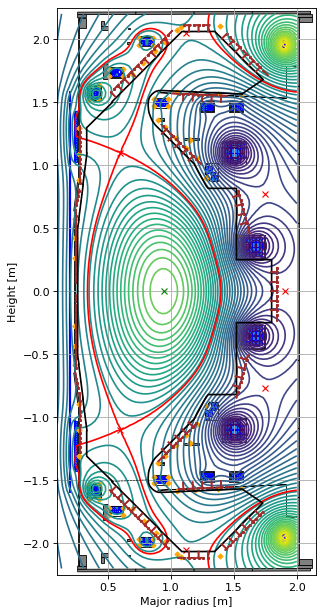

In [2]:
# build the machine
from freegsnke import build_machine

# include the paths to data files
freegsnke_tokamak = build_machine.tokamak(
    active_coils_path=os.path.expanduser("~/github/freegsnke/machine_configs/MAST-U/MAST-U_like_active_coils.pickle"),
    passive_coils_path=os.path.expanduser("~/github/freegsnke/machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"),
    limiter_path=os.path.expanduser("~/github/freegsnke/machine_configs/MAST-U/MAST-U_like_limiter.pickle"),
    wall_path=os.path.expanduser("~/github/freegsnke/machine_configs/MAST-U/MAST-U_like_wall.pickle"),
    magnetic_probe_path=os.path.expanduser("~/github/freegsnke/machine_configs/MAST-U/MAST-U_like_magnetic_probes.pickle"),
)

# initialise the equilibrium
from freegsnke import equilibrium_update

freegsnke_eq = equilibrium_update.Equilibrium(
    tokamak=freegsnke_tokamak,
    Rmin=0.1,
    Rmax=2.0,
    Zmin=-2.2,
    Zmax=2.2,
    nx=65,
    ny=129,
)

# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=freegsnke_eq,  # equilibrium object
    paxis=8e3,  # pressure at axis [pascal]
    Ip=600.0e3,  # plasma current
    fvac=0.5,  # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2,  # profile function parameter
)

# load the nonlinear solver
from freegsnke import GSstaticsolver

GSStaticSolver = GSstaticsolver.NKGSsolver(freegsnke_eq)

# set the coil currents
import pickle

with open(os.path.expanduser("~/github/freegsnke/examples/simple_diverted_currents_PaxisIp.pk"), "rb") as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    freegsnke_eq.tokamak[key].current = current_values[key]

# carry out the forward solve to find the equilibrium
GSStaticSolver.solve(eq=freegsnke_eq, profiles=profiles, constrain=None, target_relative_tolerance=1e-9)

# updates the plasma_psi
freegsnke_eq._updatePlasmaPsi(freegsnke_eq.plasma_psi)

# Initialise the sensors (calculate the Greens tables)
freegsnke_tokamak.probes.initialise_setup(freegsnke_eq)

# plot the resulting equilbria
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which="both")
freegsnke_eq.plot(axis=ax1, show=False)
freegsnke_eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
freegsnke_eq.tokamak.probes.plot(axis=ax1, show=False, floops=True, pickups=True, pickups_scale=0.05)
plt.tight_layout()

# 2. Equilibrium reconstruction with GSFit
## 2.1 GSFit, magnetic only reconstruction
We shall now use the sensor values from FreeGSNKE as "measured" values for GSFit equilibrium reconstruction.

Note, the `settings_path="mastu_with_synthetic_data_from_freegsnke"` specifies which directory to load the *.json settings from.
The settings directory constains a list of magnetic probes, e.g. `sensor_weights_bp_probe.json` along with weights, expected values, and wheter to use the sensor in the reconstruction.

In [3]:
# Setup GSFit using the settings for MAST-U.
gsfit_controller = Gsfit(
    pulseNo=0,
    run_name="test",
    settings_path="mastu_with_synthetic_data_from_freegsnke",
    write_to_mds=False,
)

# GSFit is naturally a time-dependent code
time = np.array([0.0, 1.0])
freegsnke_eqs = [freegsnke_eq, freegsnke_eq]  # we could extend this example to include time-dependent equilibria

# Solve the equilibrium reconstruction using the FreeGSNKE equilibrium object as measurements
gsfit_controller.run(
    time=time,
    freegsnke_eqs=freegsnke_eqs,
)

# We can now access the results from the GSFit reconstruction
plasma = gsfit_controller.plasma
flux_loops = gsfit_controller.flux_loops
bp_probes = gsfit_controller.bp_probes

2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "GSFIT_code_settings.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "passive_dof_regularisation.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_bp_probe.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_dialoop.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_flux_loops.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_isoflux.json"
2025-10-26 11:01:51  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_pressure.json"
2025-10-26 11:01:51  |  GSFI

In [4]:
# To see what is inside the `plasma` object, we can print the keys (this works the same for other objects like `flux_loops` and `bp_probes`):
plasma.print_keys()

# To access data from the `plasma` object, we can use `get_***` methods, such as `get_array1`, `get_array2`, etc.
# Rust is a strictly typed language; this is why we need to specify the type of data we want to extract.
# For example, let's extract `time` and `Ip` from the plasma object:
gsfit_time = plasma.get_array1(["time"])
gsfit_Ip = plasma.get_array1(["global", "ip"])

["global", "beta_n"]                             -> Array1<f64>;  shape=(1)
["global", "beta_p_1"]                           -> Array1<f64>;  shape=(1)
["global", "beta_p_2"]                           -> Array1<f64>;  shape=(1)
["global", "beta_p_3"]                           -> Array1<f64>;  shape=(1)
["global", "beta_t"]                             -> Array1<f64>;  shape=(1)
["global", "bt_vac_at_r_geo"]                    -> Array1<f64>;  shape=(1)
["global", "chi_mag"]                            -> Array1<f64>;  shape=(1)
["global", "delta_z"]                            -> Array1<f64>;  shape=(1)
["global", "elongation"]                         -> Array1<f64>;  shape=(1)
["global", "gs_error"]                           -> Array1<f64>;  shape=(1)
["global", "i_rod"]                              -> Array1<f64>;  shape=(1)
["global", "ip"]                                 -> Array1<f64>;  shape=(1)
["global", "li_1"]                               -> Array1<f64>;  shape=(1)
["global", "

## 2.1 Comparison between FreeGSNKE and GSFit equilibrium reconstruction (magnetic only)

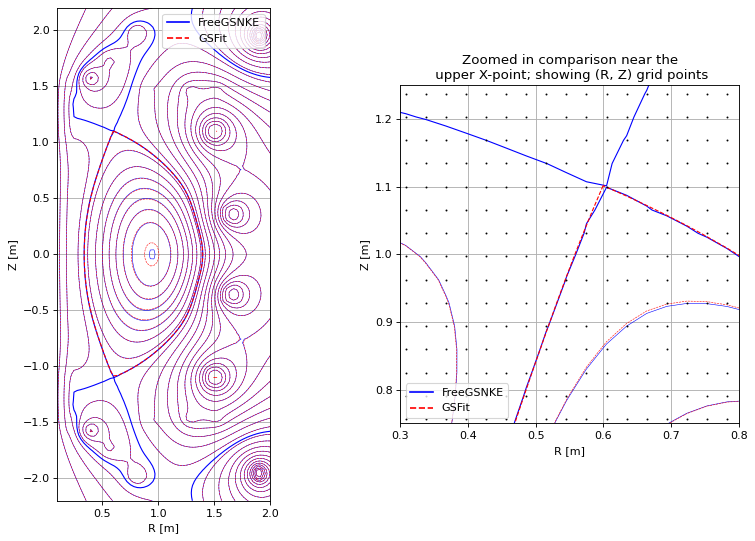

In [5]:
def plot_2d_equilibrium(freegsnke_eq, gsfit_controller):
    # Get results out of GSFit
    plasma = gsfit_controller.plasma
    i_time = 0
    gsfit_r = plasma.get_array1(["grid", "r"])
    gsfit_z = plasma.get_array1(["grid", "z"])
    gsfit_psi = plasma.get_array3(["two_d", "psi"])[i_time, :, :]
    gsfit_rbnd = plasma.get_array2(["p_boundary", "rbnd"])[i_time, :]
    gsfit_zbnd = plasma.get_array2(["p_boundary", "zbnd"])[i_time, :]
    gsfit_nbnd = plasma.get_vec_usize(["p_boundary", "nbnd"])[i_time]

    # Get results out of FreeGSNKE
    freegsnke_r = freegsnke_eq.R
    freegsnke_z = freegsnke_eq.Z
    freegsnke_psi = freegsnke_eq.psi() * (2.0 * np.pi)  # convert from "weber/(2*pi)" to "weber"
    freegsnke_psi_b = freegsnke_eq.psi_bndry * (2.0 * np.pi)

    # We will plot the same psi values for both FreeGSNKE and GSFit
    psi_range = np.linspace(np.min(freegsnke_psi), np.max(freegsnke_psi), 25)

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), dpi=80)
    for i_axis in range(2):
        ax[i_axis].grid(True, which="both")
        ax[i_axis].set_aspect("equal")
        ax[i_axis].contour(
            freegsnke_r,
            freegsnke_z,
            freegsnke_psi,
            levels=psi_range,
            colors="blue",
            linewidths=0.5,
            linestyles="solid",
        )
        ax[i_axis].contour(
            freegsnke_r,
            freegsnke_z,
            freegsnke_psi,
            levels=[freegsnke_psi_b],
            colors="blue",
            linewidths=1.0,
            linestyles="solid",
        )
        ax[i_axis].contour(
            gsfit_r,
            gsfit_z,
            gsfit_psi,
            levels=psi_range,
            colors="red",
            linewidths=0.5,
            linestyles="dashed",
        )
        ax[i_axis].plot(
            gsfit_rbnd[0:gsfit_nbnd],
            gsfit_zbnd[0:gsfit_nbnd],
            color="red",
            linewidth=1.0,
            linestyle="dashed",
        )
        ax[i_axis].set_xlabel("R [m]")
        ax[i_axis].set_ylabel("Z [m]")
        ax[i_axis].plot([], [], label="FreeGSNKE", color="blue")
        ax[i_axis].plot([], [], label="GSFit", linestyle="dashed", color="red")
        ax[i_axis].legend()

    ax[1].set_xlim(0.3, 0.8)
    ax[1].set_ylim(0.75, 1.25)
    [r_mesh, z_mesh] = np.meshgrid(freegsnke_eq.R_1D, freegsnke_eq.Z_1D)
    ax[1].plot(r_mesh.flatten(), z_mesh.flatten(), "o", color="black", markersize=0.75)
    ax[1].set_title("Zoomed in comparison near the\n upper X-point; showing (R, Z) grid points")


plot_2d_equilibrium(freegsnke_eq, gsfit_controller)

In the figure above we compare the poloidal flux from FreeGSNKE and GSFit (note the contours have the same value).
We see excellent agreement in the vacuum, but some discrepancy in the core.
This is to be expected, as we have not supplied any internal measurements and this is a magnetics only equilibrium reconstruction.

Text(0, 0.5, 'Flux [Wb]')

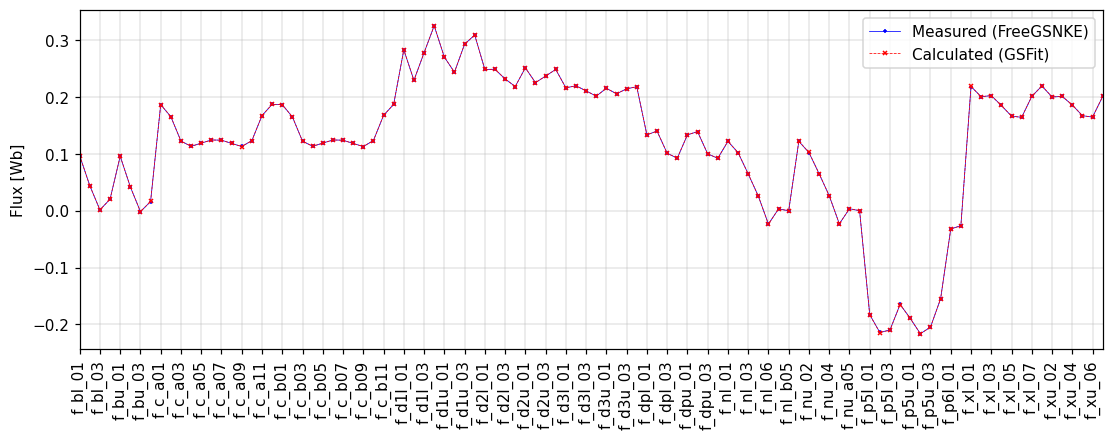

In [6]:
# Compare flux_loops measured vs calculated value
i_time = 0
flux_loops_names = flux_loops.keys()
flux_loops_measured = flux_loops.get_array2(["*", "psi", "measured"])[i_time, :]
flux_loops_calculated = flux_loops.get_array2(["*", "psi", "calculated"])[i_time, :]

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=110)
ax.plot(
    flux_loops_names,
    flux_loops_measured,
    label="Measured (FreeGSNKE)",
    color="blue",
    linewidth=0.5,
    marker="+",
    markersize=2.5,
)
ax.plot(
    flux_loops_names,
    flux_loops_calculated,
    label="Calculated (GSFit)",
    color="red",
    linestyle="dashed",
    linewidth=0.5,
    marker="x",
    markersize=2.5,
)
ax.tick_params(axis="x", rotation=90.0)
ax.set_xticks(range(0, len(flux_loops_names), 2))
ax.tick_params(axis="x", which="minor", pad=-20)
ax.grid(True, which="both", linewidth=0.3)
ax.set_xlim(0, len(flux_loops_names) - 1)
ax.legend()
ax.set_ylabel("Flux [Wb]")

Text(0, 0.5, 'Field [T]')

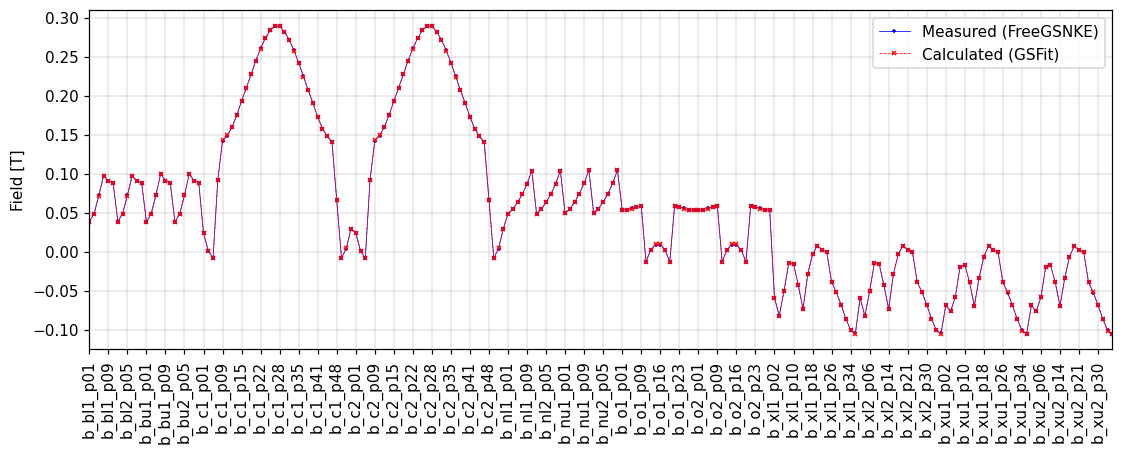

In [7]:
# Compare bp_probes measured vs calculated value
bp_probes_names = bp_probes.keys()
bp_probes_measured = bp_probes.get_array2(["*", "b", "measured"])[i_time, :]
bp_probes_calculated = bp_probes.get_array2(["*", "b", "calculated"])[i_time, :]

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=110)
ax.plot(
    bp_probes_names,
    bp_probes_measured,
    label="Measured (FreeGSNKE)",
    color="blue",
    linewidth=0.5,
    marker="+",
    markersize=2.5,
)
ax.plot(
    bp_probes_names,
    bp_probes_calculated,
    label="Calculated (GSFit)",
    color="red",
    linestyle="dashed",
    linewidth=0.5,
    marker="x",
    markersize=2.5,
)
ax.tick_params(axis="x", rotation=90.0)
ax.set_xticks(range(0, len(bp_probes_names), 4))
ax.tick_params(axis="x", which="minor", pad=-20)
ax.grid(True, which="both", linewidth=0.3)
ax.set_xlim(0, len(bp_probes_names) - 1)
ax.legend()
ax.set_ylabel("Field [T]")

In [ ]:
# # Check that the reconstructed plasma current is within 0.5 kA of the simulated plasma current
# reconstructed_ip = gsfit_controller["GLOBAL"]["IP"][i_time]
# print(f"Reconstructed Ip = {reconstructed_ip/1e3:.2f} kA")
# assert np.abs(reconstructed_ip - 600e3) < 0.5e3

Reconstructed Ip = 600.01 kA


In [26]:
# Test the differences between the two assertion methods
import numpy as np

# Let's examine what the actual tolerance values are
rtol = 1e-3
expected = 600e3
relative_tolerance = rtol * expected  # This is 600.0 (600 A)
absolute_tolerance = 0.5e3  # This is 500.0 (500 A)

print(f"Relative tolerance (rtol=1e-3): {relative_tolerance} A")
print(f"Absolute tolerance: {absolute_tolerance} A")
print(f"Relative tolerance is {'larger' if relative_tolerance > absolute_tolerance else 'smaller'} than absolute tolerance")
print()

# Test edge cases that might behave differently
test_values = [600e3, 600.1e3, 600.5e3, 600.6e3, 599.5e3, 599.4e3]

for test_val in test_values:
    abs_diff = np.abs(test_val - 600e3)
    is_close = np.isclose(test_val, 600e3, rtol=1e-3)
    abs_check = abs_diff < 0.5e3
    
    print(f"Value: {test_val/1e3:.1f} kA, Diff: {abs_diff:.0f} A")
    print(f"  abs() < 0.5e3: {abs_check} (type: {type(abs_check)})")
    print(f"  np.isclose():   {is_close} (type: {type(is_close)})")
    print(f"  Same result: {abs_check == is_close}")
    print()

# Check if there are any floating point precision issues
print("Checking floating point precision:")
print(f"600e3 == 600000.0: {600e3 == 600000.0}")
print(f"type(600e3): {type(600e3)}")
print(f"type(0.5e3): {type(0.5e3)}")
print(f"type(1e-3): {type(1e-3)}")

Relative tolerance (rtol=1e-3): 600.0 A
Absolute tolerance: 500.0 A
Relative tolerance is larger than absolute tolerance

Value: 600.0 kA, Diff: 0 A
  abs() < 0.5e3: True (type: <class 'numpy.bool'>)
  np.isclose():   True (type: <class 'numpy.bool'>)
  Same result: True

Value: 600.1 kA, Diff: 100 A
  abs() < 0.5e3: True (type: <class 'numpy.bool'>)
  np.isclose():   True (type: <class 'numpy.bool'>)
  Same result: True

Value: 600.5 kA, Diff: 500 A
  abs() < 0.5e3: False (type: <class 'numpy.bool'>)
  np.isclose():   True (type: <class 'numpy.bool'>)
  Same result: False

Value: 600.6 kA, Diff: 600 A
  abs() < 0.5e3: False (type: <class 'numpy.bool'>)
  np.isclose():   True (type: <class 'numpy.bool'>)
  Same result: False

Value: 599.5 kA, Diff: 500 A
  abs() < 0.5e3: False (type: <class 'numpy.bool'>)
  np.isclose():   True (type: <class 'numpy.bool'>)
  Same result: False

Value: 599.4 kA, Diff: 600 A
  abs() < 0.5e3: False (type: <class 'numpy.bool'>)
  np.isclose():   True (type

In [9]:
def plot_pressure_along_mid_plane(freegsnke_eq, gsfit_controller):
    # Calculate the pressure on the mid-plane, for FreeGSNKE
    freegsnke_mid_plane_r = freegsnke_eq.R_1D
    freegsnke_mid_plane_z = 0.0 * freegsnke_mid_plane_r
    freegsnke_mid_plane_psi_n = freegsnke_eq.psiNRZ(freegsnke_mid_plane_r, freegsnke_mid_plane_z)
    freegsnke_mid_plane_pressure = freegsnke_eq.pressure(freegsnke_mid_plane_psi_n)

    # Calculate the pressure on the mid-plane, for GSFit
    plasma = gsfit_controller.plasma
    gsfit_p_mid_plane = plasma.get_array2(["profiles", "mid_plane", "p"])
    gsfit_r_mid_plane = plasma.get_array1(["profiles", "mid_plane", "r"])

    # Create figure
    plt.figure()

    # Plot the pressure on the mid-plane, for FreeGSNKE
    plt.plot(
        freegsnke_mid_plane_r,
        freegsnke_mid_plane_pressure,
        color="blue",
        label="FreeGSNKE",
        linewidth=0.5,
    )

    # Plot the pressure on the mid-plane, for GSFit
    plt.plot(
        gsfit_r_mid_plane,
        gsfit_p_mid_plane[0, :],
        label="GSFit",
        color="red",
        linestyle="dashed",
        linewidth=0.5,
    )
    plt.gca().set_xlabel("$R$ [m]")
    plt.gca().set_ylabel("$P$ [Pa]")

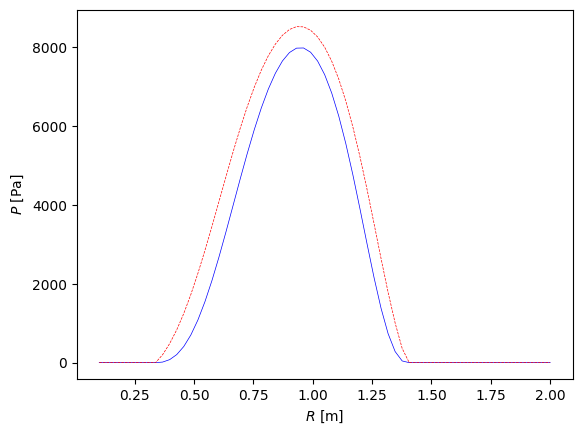

In [10]:
plot_pressure_along_mid_plane(freegsnke_eq, gsfit_controller)

## 2.3 GSFit, magnetic + isoflux reconstruction
We have already observed an excellent reconstruction of the last closed flux surface.
However, the reconstruction of the pressure profile in the core, while close, is not exactly reconstructed.
This is to be expected, as there were no internal measurements.

We shall now try adding `isoflux` constraints.
This requires us to specify two coordinates that have equal poloidal flux.
To do this, we shall specify two HFS coordinates, interpolate the pressure, and find the corresponding LFS coordinate.

In [11]:
# Function to find the second location of the isoflux
def find_location_2_r(location_1_r, freegsnke_eq):
    # Note: This function assumes that we have kinetic measurements on the mid-plane.
    n_isoflux = len(location_1_r)

    # FreeGSNKE mid-plane pressure
    freegsnke_mid_plane_r = freegsnke_eq.R_1D
    freegsnke_mid_plane_z = 0.0 * freegsnke_mid_plane_r
    freegsnke_mid_plane_psi_n = freegsnke_eq.psiNRZ(freegsnke_mid_plane_r, freegsnke_mid_plane_z)
    freegsnke_mid_plane_pressure = freegsnke_eq.pressure(freegsnke_mid_plane_psi_n)

    # Find the pressure at (location_1_r, location_1_z); assuming location_1_z is 0.0
    location_2_r = np.full(n_isoflux, np.nan)
    isoflux_pressure = np.full(n_isoflux, np.nan)
    for i_isoflux in range(n_isoflux):
        pressure_line = shapely.geometry.LineString(np.column_stack((freegsnke_mid_plane_r, freegsnke_mid_plane_pressure)))
        line = shapely.geometry.LineString(np.column_stack(([location_1_r[i_isoflux], location_1_r[i_isoflux]], [0.0, 1e8])))
        isoflux_pressure_intersection = pressure_line.intersection(line)
        isoflux_pressure[i_isoflux] = isoflux_pressure_intersection.y

        isoflux_line = shapely.geometry.LineString(np.column_stack(([0.0, 10.0], [isoflux_pressure[i_isoflux], isoflux_pressure[i_isoflux]])))

        isoflux_intersections = isoflux_line.intersection(pressure_line)

        location_2_r[i_isoflux] = isoflux_intersections.geoms[1].x

    return location_2_r, isoflux_pressure


def plot_isoflux(freegsnke_eq, gsfit_controller, location_1_r, location_2_r, isoflux_pressure):
    # Plot the isoflux locations
    plot_pressure_along_mid_plane(freegsnke_eq, gsfit_controller)

    # Plot the isoflux locations
    n_isoflux = len(location_1_r)
    for i_isoflux in range(n_isoflux):
        plt.plot(
            [location_1_r[i_isoflux], location_2_r[i_isoflux]],
            [isoflux_pressure[i_isoflux], isoflux_pressure[i_isoflux]],
            color="black",
            linewidth=0.5,
            marker="o",
            markersize=5.0,
        )

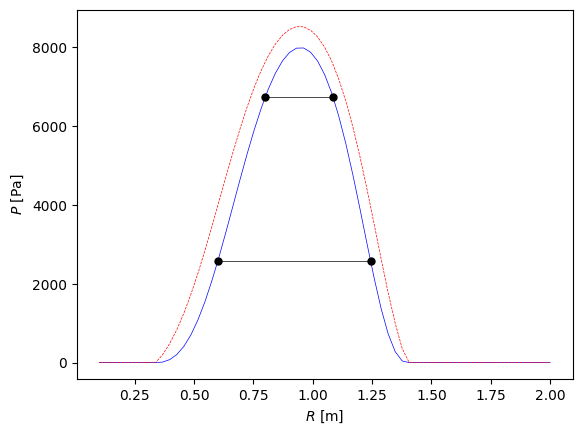

In [12]:
# Calculate the pressure on the mid-plane, using FreeGSNKE
# We shall define two isoflux locations
location_1_r = np.array([0.6, 0.8])
location_1_z = np.array([0.0, 0.0])
location_2_z = np.array([0.0, 0.0])
location_2_r, isoflux_pressure = find_location_2_r(location_1_r, freegsnke_eq)
# Note: `isoflux_pressure` is only for plotting.

plot_isoflux(freegsnke_eq, gsfit_controller, location_1_r, location_2_r, isoflux_pressure)

In [13]:
isoflux = gsfit_rs.Isoflux()

times_to_reconstruct = gsfit_controller.results["TIME"]

n_time = 2
# Add an isoflux constraint to the GSFit controller
for i_isoflux in range(len(location_1_r)):
    isoflux.add_sensor(
        name=f"isoflux_constraint_{i_isoflux + 1}",
        fit_settings_comment="",
        fit_settings_include=True,
        fit_settings_weight=30.0,  # Large weight
        time=time,
        location_1_r=np.array([location_1_r[i_isoflux]] * n_time).astype(np.float64),
        location_1_z=np.array([0.0] * n_time).astype(np.float64),
        location_2_r=np.array([location_2_r[i_isoflux]] * n_time).astype(np.float64),
        location_2_z=np.array([0.0] * n_time).astype(np.float64),
        times_to_reconstruct=times_to_reconstruct,
    )

# Add the isoflux constraint to the GSFit controller
gsfit_controller.isoflux = isoflux

# We need to re-calculate the Greens tables
gsfit_controller.calculate_greens()

# Run the inverse solver
gsfit_controller.inverse_solver_rust()

include_dynamic = [true]
include_dynamic = [true]
2025-10-26 11:02:09  |  GSFIT  |  gsfit.py:232                           |  INFO  |  Finished Greens with coils;  5,683.40ms
2025-10-26 11:02:09  |  GSFIT  |  gsfit.py:243                           |  INFO  |  Finished Greens with passives;  1.47ms
2025-10-26 11:02:09  |  GSFIT  |  gsfit.py:253                           |  INFO  |  Finished Greens with plasma;  705.90ms
2025-10-26 11:02:09  |  GSFIT  |  gsfit.py:185                           |  INFO  |  About to call: `gsfit_rs.solve_inverse_problem`
solve_inverse_problem starting
2025-10-26 11:02:13  |  GSFIT  |  gsfit.py:206                           |  INFO  |  Finished: `gsfit_rs.solve_inverse_problem` time = 3,672.45ms
include_dynamic = [true]
include_dynamic = [true]
time= 500.0ms;  solution_found=true;  gs_error=0.000002550114879706584;  n_iter=9
equilibrium_post_processor: starting


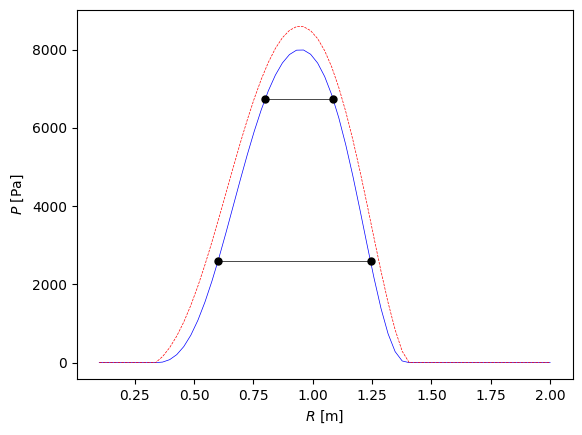

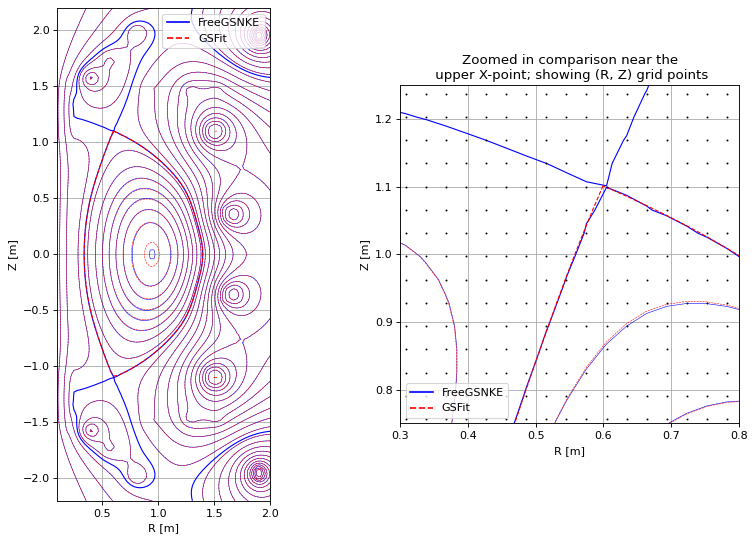

In [14]:
# Plot how the results have changed with the isoflux constraint
plot_isoflux(freegsnke_eq, gsfit_controller, location_1_r, location_2_r, isoflux_pressure)
plot_2d_equilibrium(freegsnke_eq, gsfit_controller)

We observe that the 2D equilibrium is unchanged.
The pressure profile now has the same shape as FreeGSNKE, but the magnitude is not correct.
To further improve the equilibrium reconstruction, we will need to add in pressure constraints.